## NLP Draft Predictions

In [64]:
import re
import numpy as np
import pandas as pd

import matplotlib.cm as cm
import matplotlib.pyplot as plt

from sklearn.svm import SVC
from sklearn import preprocessing
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.cluster import KMeans, MiniBatchKMeans, AgglomerativeClustering
from sklearn.model_selection import train_test_split

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer, WordNetLemmatizer

import clean_reports
import preprocess_reports
import setup_predictor
#import umap

nltk.download("punkt")
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/jeremygonsalves/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/jeremygonsalves/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/jeremygonsalves/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /Users/jeremygonsalves/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [65]:
# dataset location
DATASET = "/Users/jeremygonsalves/Documents/GitHub/PredictingDraftNHL/Data/prospect-data.csv"

# load dataset into dataframe
data = clean_reports.clean(DATASET)

data.head()

,Year,Position,Height,Weight,Drafted,Team,Average Ranking,Name,Description - Corey Pronman,Description - Scott Wheeler,Description - Smaht Scouting,Description - ESPN (Chris Peters),Description - EP Rinkside,Description - EP Rinkside Part 2,Description - The Painted Lines,Description - FCHockey
0,2023,0,-1.327212,-0.127585,NaN,32,1.0,Connor Bedard,Bedard is a potential franchise-changing No. 1...,Bedard’s statistical profile speaks for itself...,Connor Bedard is an extremely gifted generatio...,One of the most naturally gifted goal scorers ...,NaN,Connor Bedard is the premier prospect in the w...,NaN,NaN
1,2023,0,0.594434,0.003256,NaN,32,2.0,Adam Fantilli,There's so much to love about Fantilli's NHL p...,"Fantilli is a big, strong, powerful center who...",Adam Fantilli has every tool that an NHL team ...,"A 6-foot-2, 200-pound power center with touch,...",NaN,"A fantastic consolation prize, Adam Fantilli w...",NaN,NaN
2,2023,4,-1.214174,-2.548154,NaN,32,3.0,Matvei Michkov,Michkov is one of the very best first-year dra...,Michkov is the best Russian prospect since Ale...,"A smart, dynamic goal-scoring winger, Michkov ...","For the last few years, I’ve described Michkov...",NaN,"Statistically, Matvei Michkov is *another* fir...",NaN,NaN
3,2023,0,1.046586,0.461202,NaN,32,4.0,Leo Carlsson,"Carlsson has elite skill, which when combined ...",Though he doesn’t play the game with some of t...,Carlsson has been played extremely well at the...,The buzz is growing (and rightfully so) that C...,NaN,"Oh, look, another first-overall talent. Leo Ca...",NaN,NaN
4,2023,3,-1.327212,-1.108897,NaN,32,5.0,Zach Benson,Benson has a ton of creativity and offense in ...,"There were a lot of nights last season, on an ...",While I don’t necessarily see Zach Benson reac...,"An offensive dynamo with deft scoring touch, B...",NaN,Some people are worried about selecting a 5-9 ...,NaN,NaN


In [66]:
data.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 402 entries, 0 to 401
Data columns (total 16 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   Year                               402 non-null    int64  
 1   Position                           402 non-null    int64  
 2   Height                             402 non-null    float64
 3   Weight                             402 non-null    float64
 4   Drafted                            360 non-null    float64
 5   Team                               402 non-null    int64  
 6   Average Ranking                    162 non-null    float64
 7   Name                               402 non-null    object 
 8   Description - Corey Pronman        389 non-null    object 
 9   Description - Scott Wheeler        213 non-null    object 
 10  Description - Smaht Scouting       149 non-null    object 
 11  Description - ESPN (Chris Peters)  229 non-null    object 

## Exploratory Data Analysis

This visualization explores the accuracy/predictiveness of the `Average Ranking` feature in the dataset. **How well does `Average Ranking` predict the actual draft position?** We find that for the highly ranked players, the average ranking statistic seems pretty accurate as it follows well with a close resemblance to a 1-1 correspondence to the actual draft position (as indicated by conformance to the y=x line). However, for lower ranked players, there is more variation in their actual draft prediction (as shown by the spread and deviation from the y=x line).

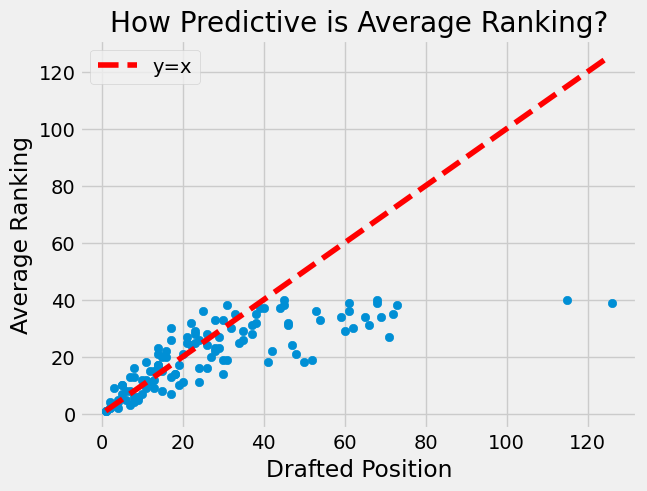

In [67]:
# define the y=x line for perfect alignment where the average
#   player ranking would have predicted the draft position
xx = np.arange(data['Drafted'].min(), data['Drafted'].max())
yy = xx

plt.scatter(data['Drafted'], data['Average Ranking'])
plt.plot(xx, yy, 'r--', label="y=x")
plt.xlabel("Drafted Position")
plt.ylabel("Average Ranking")
plt.legend()
plt.title("How Predictive is Average Ranking?")
plt.show()


From observing the count of non-missing values from the `Dataframe.info()` method, we may ask: **Why are there so many missing values for the `Average Ranking` feature?** After a bit of exploration, we find that scouting reports sourced prior to 2020 did not have this feature. 

In [68]:
mask = data['Average Ranking'].isnull()
for year, value in data[mask].groupby('Year').count().iloc[:,0].reset_index().to_numpy():
    print(f"For scouting reports with a missing value for `Average Ranking`, {value} come from {year}")

for year, value in data[~mask].groupby('Year').count().iloc[:,0].reset_index().to_numpy():
    print(f"For scouting reports with a value for `Average Ranking`, {value} come from {year}")

For scouting reports with a missing value for `Average Ranking`, 40 come from 2014
For scouting reports with a missing value for `Average Ranking`, 40 come from 2015
For scouting reports with a missing value for `Average Ranking`, 40 come from 2016
For scouting reports with a missing value for `Average Ranking`, 40 come from 2017
For scouting reports with a missing value for `Average Ranking`, 40 come from 2018
For scouting reports with a missing value for `Average Ranking`, 40 come from 2019
For scouting reports with a value for `Average Ranking`, 40 come from 2020
For scouting reports with a value for `Average Ranking`, 40 come from 2021
For scouting reports with a value for `Average Ranking`, 40 come from 2022
For scouting reports with a value for `Average Ranking`, 42 come from 2023


- Why is the `Average Ranking` feature encoded as a float type instead of an int type?
    - `Average Ranking` seems to be more appropriate as a int type, but we are not fully confident due to not knowing the method of computation for this feature. There is not a significant memory issue either.

In [69]:
data[~data['Average Ranking'].isnull()]['Average Ranking']

0       1.0
1       2.0
2       3.0
3       4.0
4       5.0
       ... 
157    36.0
158    37.0
159    38.0
160    39.0
161    40.0
Name: Average Ranking, Length: 162, dtype: float64

**What is the average scouting report length for each player? for each expert?**

In [70]:
# scouting report columns
mask = data.columns.str.match('Description')
scouting_reports = data.columns[mask]

# create a temporary DataFrame that stores the token length of each scouting 
#   report instead of the actual text
token_count_df = data.copy(deep=True)

for report in scouting_reports:
    token_count_df[report] = token_count_df[report].apply(
        lambda x: len(word_tokenize(x)) if isinstance(x,str) else np.nan
    )

In [71]:
# average scouting report for each expert
token_count_df[scouting_reports].mean().sort_values()


Description - EP Rinkside             89.803797
Description - The Painted Lines      146.406015
Description - ESPN (Chris Peters)    151.436681
Description - Corey Pronman          174.683805
Description - Smaht Scouting         239.865772
Description - Scott Wheeler          263.450704
Description - FCHockey               361.660000
Description - EP Rinkside Part 2     471.338624
dtype: float64

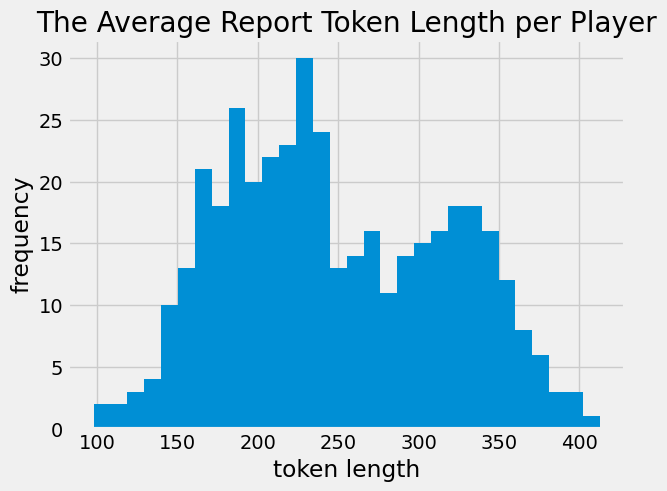

In [72]:
# average scouting report for each player
mean_token_length_per_player = pd.melt(
    token_count_df, 
    id_vars=['Name'], 
    value_vars=scouting_reports,
    var_name='scouting_report',
    value_name='token_count'
).groupby('Name')['token_count'].mean()

plt.hist(mean_token_length_per_player, bins=30)
plt.xlabel("token length")
plt.ylabel("frequency")
plt.title("The Average Report Token Length per Player")
plt.show()

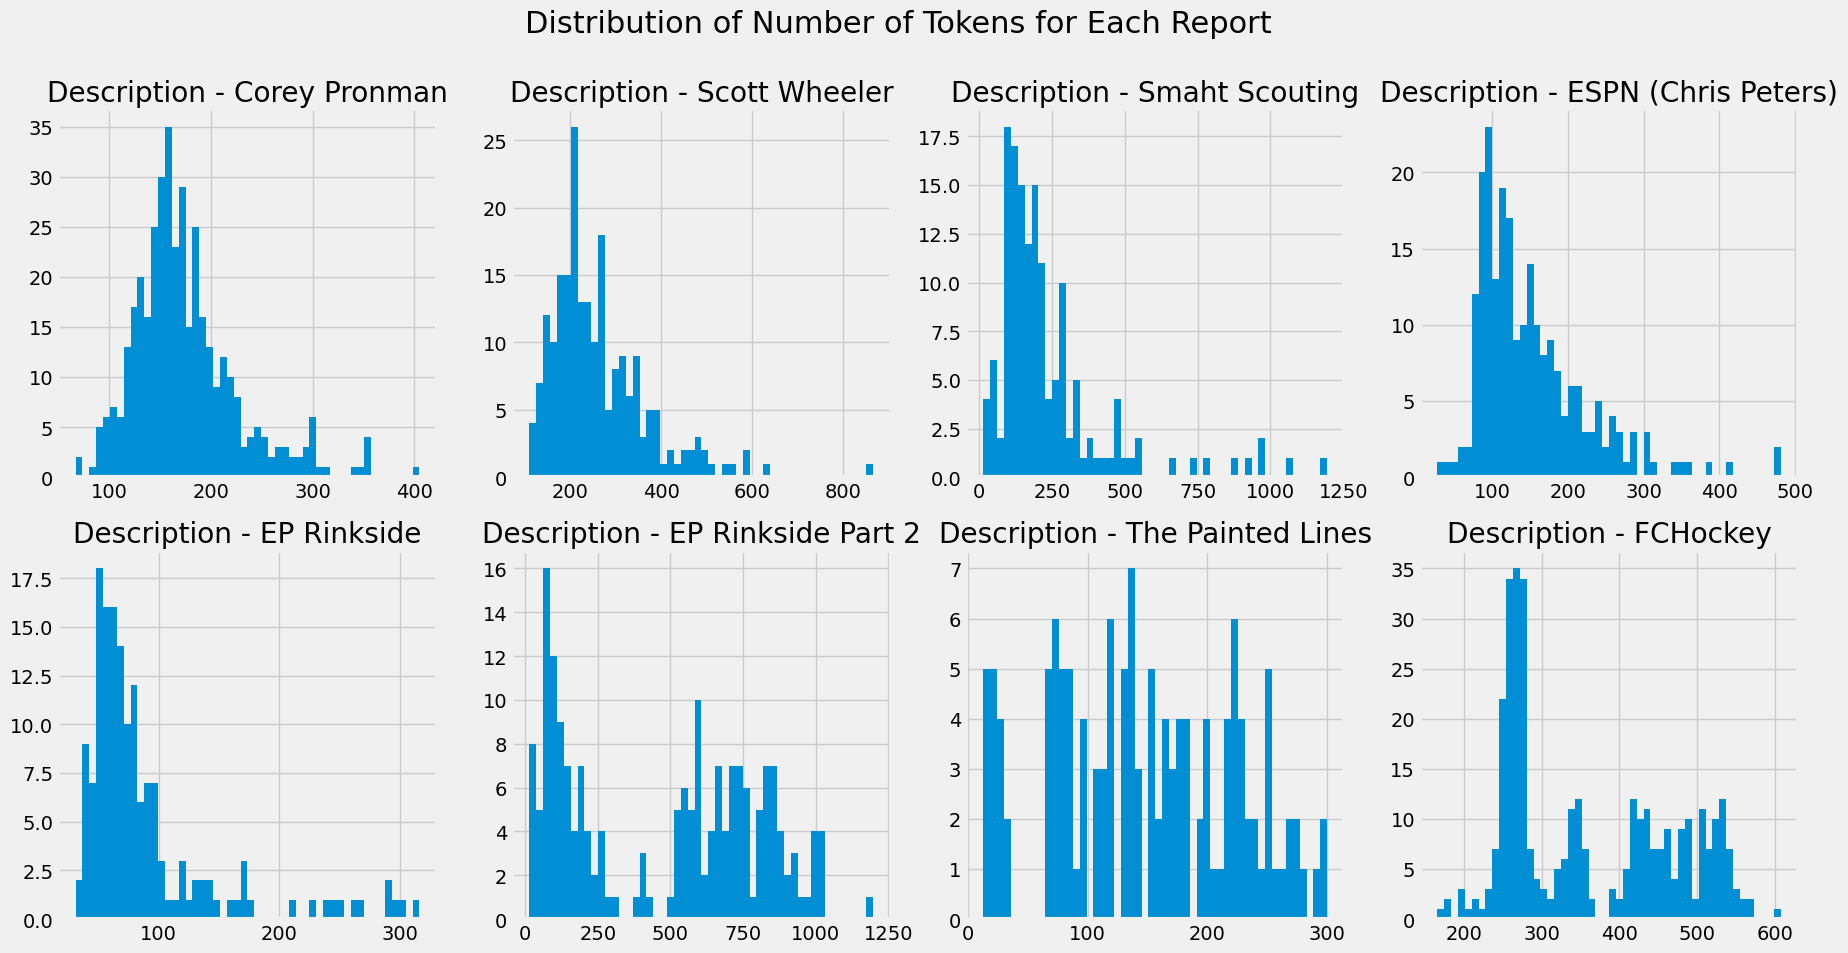

In [73]:
nrows = 2
ncols = 4
fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=(20,10))
for index, report in enumerate(scouting_reports):
    i,j = [array[0] for array in np.unravel_index([index], shape=(nrows,ncols))]
    ax[i,j].hist(token_count_df[report].values, bins=50)
    ax[i,j].set_title(report)

plt.suptitle("Distribution of Number of Tokens for Each Report", fontsize=22)
plt.show()

In [74]:
# Check the length of each name
data['Name'].apply(len).sort_values()

218     8
238     8
311     9
142     9
305     9
       ..
8      20
49     20
227    20
33     21
264    21
Name: Name, Length: 402, dtype: int64

**Is there an unequal distribution between player positions? (e.g., a lot more forwards than defenders)**

In [75]:
# global variable that encodes the name of each hockey position
#   could be useful for visualization later on
HOCKEY_POSITIONS = {
    'C' : 'Center',
    'D' : 'Defender',
    'RW' : 'Right Wing',
    'LW' : 'Left Wing',
    'G' : 'Goalie'
}

# distribution of player positions
data['Position'].value_counts()

Position
0    134
1    116
4     78
3     60
2     14
Name: count, dtype: int64

## Data Cleaning

In [76]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 402 entries, 0 to 401
Data columns (total 16 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   Year                               402 non-null    int64  
 1   Position                           402 non-null    int64  
 2   Height                             402 non-null    float64
 3   Weight                             402 non-null    float64
 4   Drafted                            360 non-null    float64
 5   Team                               402 non-null    int64  
 6   Average Ranking                    162 non-null    float64
 7   Name                               402 non-null    object 
 8   Description - Corey Pronman        389 non-null    object 
 9   Description - Scott Wheeler        213 non-null    object 
 10  Description - Smaht Scouting       149 non-null    object 
 11  Description - ESPN (Chris Peters)  229 non-null    object 

In [77]:
# preprocess data with NLTK
preprocessed_df = data.copy()
for report in scouting_reports:
    report_preprocessor = preprocess_reports.NltkPreprocessor(data[report])
    preprocessed_df.loc[:,report] = report_preprocessor\
        .remove_names(data['Name'])\
        .remove_whitespace()\
        .get_text()


In [78]:
# transform from wide to long data frame
long_df = preprocessed_df.melt(
    id_vars=['Year', 'Position', 'Height', 'Weight', 'Drafted', 'Team', 'Average Ranking', 'Name'],
    value_vars=scouting_reports.tolist(),
    var_name='reporter',  
    value_name='text'
)

In [79]:
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from Model import SVMOrdinalClassifier

# setup model architecture
numeric_cols = ['Height', 'Weight']
categorical_cols = ['Position', 'reporter']
# text_cols = scouting_reports.tolist()
text_cols = ['text']
model = setup_predictor.setup(
    numeric_cols=numeric_cols, 
    categorical_cols=categorical_cols,
    text_cols=text_cols,
    func=RandomForestClassifier()
)

In [80]:
subset_long_df = long_df.sample(frac=0.2)

X = subset_long_df[numeric_cols + categorical_cols + text_cols]
y = subset_long_df['Drafted']

# Remove rows where y contains NaN
non_nan_indices = y.dropna().index
X = X.loc[non_nan_indices]
y = y.loc[non_nan_indices]

# create train test splits of data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.33, random_state=42
)

# Ensure the model is correctly instantiated without conflicting argument

# train model
model.fit(X_train, y_train)

Pipeline(steps=[('features',
                 ColumnTransformer(transformers=[('numeric',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scalar',
                                                                   StandardScaler())]),
                                                  ['Height', 'Weight']),
                                                 ('categorical',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(fill_value=' ',
                                                                                 strategy='constant')),
                                                                  ('encoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['Position', 'reporter']),
                                                 ('text',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(fill_value=' ',
                                                                                 strategy='constant')),
                                                                  ('selector',
                                                                   FunctionTransformer(func=<function _get_text_data at 0x134454040>)),
                                                                  ('vectorizer',
                                                                   TfidfVectorizer(max_df=0.5,
                                                                                   min_df=0.04,
                                                                                   ngram_range=(1,
                                                                                                3)))]),
                                                  ['text'])])),
                ('clf', RandomForestClassifier())])

In [81]:
from sklearn.metrics import f1_score, precision_score, recall_score
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# testing and obtaining metrics
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)
metrics = {
    'train_score' : model.score(X_train, y_train),
    'test_score' : model.score(X_test, y_test),
    # 'train_mae' : mean_absolute_error(y_train, y_train_pred),
    # 'test_mae' : mean_absolute_error(y_test, y_test_pred),
    # 'train_rmse' : mean_squared_error(y_train, y_train_pred, squared=False),
    # 'test_rmse' : mean_squared_error(y_test, y_test_pred, squared=False),
    # 'train_r2' : r2_score(y_train, y_train_pred),
    # 'test_r2' : r2_score(y_test, y_test_pred),
    'train_f1' : f1_score(y_train, y_train_pred, average='micro'),
    'test_f1' : f1_score(y_test, y_test_pred, average='micro'),
}
metrics

{'train_score': 0.9948186528497409,
 'test_score': 0.08376963350785341,
 'train_f1': np.float64(0.9948186528497409),
 'test_f1': np.float64(0.08376963350785341)}

Text(0.5, 1.0, 'Actual vs. Predicted Values')

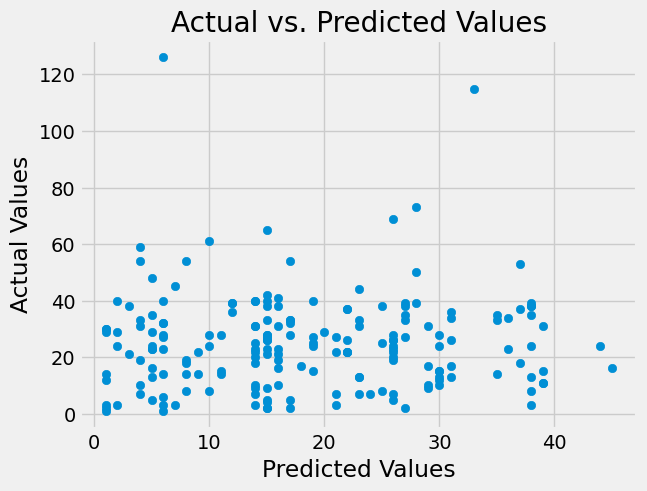

In [82]:
# plot actual vs predicted values
plt.scatter(y_test_pred, y_test)
plt.xlabel("Predicted Values")
plt.ylabel("Actual Values")
plt.title("Actual vs. Predicted Values")

## Unsupervised Learning 

Exploring Kmeans now for unsupervised learning

In [83]:
# dataset location
DATASET = "/Users/jeremygonsalves/Documents/GitHub/PredictingDraftNHL/Data/prospect-data.csv"

# load dataset into dataframe
data = pd.read_csv(DATASET)

data.head()

,Year,Position,Height,Weight,Drafted,Team,Average Ranking,Name,Description - Corey Pronman,Description - Scott Wheeler,Description - Smaht Scouting,Description - ESPN (Chris Peters),Description - EP Rinkside,Description - EP Rinkside Part 2,Description - The Painted Lines,Description - FCHockey
0,2023,C,69.75,185.0,NaN,NaN,1.0,Connor Bedard,Bedard is a potential franchise-changing No. 1...,Bedard’s statistical profile speaks for itself...,Connor Bedard is an extremely gifted generatio...,One of the most naturally gifted goal scorers ...,NaN,Connor Bedard is the premier prospect in the w...,NaN,NaN
1,2023,C,74.00,187.0,NaN,NaN,2.0,Adam Fantilli,There's so much to love about Fantilli's NHL p...,"Fantilli is a big, strong, powerful center who...",Adam Fantilli has every tool that an NHL team ...,"A 6-foot-2, 200-pound power center with touch,...",NaN,"A fantastic consolation prize, Adam Fantilli w...",NaN,NaN
2,2023,RW,70.00,148.0,NaN,NaN,3.0,Matvei Michkov,Michkov is one of the very best first-year dra...,Michkov is the best Russian prospect since Ale...,"A smart, dynamic goal-scoring winger, Michkov ...","For the last few years, I’ve described Michkov...",NaN,"Statistically, Matvei Michkov is *another* fir...",NaN,NaN
3,2023,C,75.00,194.0,NaN,NaN,4.0,Leo Carlsson,"Carlsson has elite skill, which when combined ...",Though he doesn’t play the game with some of t...,Carlsson has been played extremely well at the...,The buzz is growing (and rightfully so) that C...,NaN,"Oh, look, another first-overall talent. Leo Ca...",NaN,NaN
4,2023,LW,69.75,170.0,NaN,NaN,5.0,Zach Benson,Benson has a ton of creativity and offense in ...,"There were a lot of nights last season, on an ...",While I don’t necessarily see Zach Benson reac...,"An offensive dynamo with deft scoring touch, B...",NaN,Some people are worried about selecting a 5-9 ...,NaN,NaN


In [84]:
# encode position
# TODO: we should keep the positions for when we do clustering
le = preprocessing.LabelEncoder()
le.fit(data['Position'].unique())
data['Position'] = data['Position'].apply(lambda x: le.transform([x])[0])

height_scaler = preprocessing.MinMaxScaler()
data['Height'] = height_scaler.fit_transform(data['Height'].values.reshape(-1, 1))
weight_scaler = preprocessing.MinMaxScaler()
data['Weight'] = weight_scaler.fit_transform(data['Weight'].values.reshape(-1, 1))


data.head()

,Year,Position,Height,Weight,Drafted,Team,Average Ranking,Name,Description - Corey Pronman,Description - Scott Wheeler,Description - Smaht Scouting,Description - ESPN (Chris Peters),Description - EP Rinkside,Description - EP Rinkside Part 2,Description - The Painted Lines,Description - FCHockey
0,2023,0,0.277778,0.278499,NaN,NaN,1.0,Connor Bedard,Bedard is a potential franchise-changing No. 1...,Bedard’s statistical profile speaks for itself...,Connor Bedard is an extremely gifted generatio...,One of the most naturally gifted goal scorers ...,NaN,Connor Bedard is the premier prospect in the w...,NaN,NaN
1,2023,0,0.592593,0.292929,NaN,NaN,2.0,Adam Fantilli,There's so much to love about Fantilli's NHL p...,"Fantilli is a big, strong, powerful center who...",Adam Fantilli has every tool that an NHL team ...,"A 6-foot-2, 200-pound power center with touch,...",NaN,"A fantastic consolation prize, Adam Fantilli w...",NaN,NaN
2,2023,4,0.296296,0.011544,NaN,NaN,3.0,Matvei Michkov,Michkov is one of the very best first-year dra...,Michkov is the best Russian prospect since Ale...,"A smart, dynamic goal-scoring winger, Michkov ...","For the last few years, I’ve described Michkov...",NaN,"Statistically, Matvei Michkov is *another* fir...",NaN,NaN
3,2023,0,0.666667,0.343434,NaN,NaN,4.0,Leo Carlsson,"Carlsson has elite skill, which when combined ...",Though he doesn’t play the game with some of t...,Carlsson has been played extremely well at the...,The buzz is growing (and rightfully so) that C...,NaN,"Oh, look, another first-overall talent. Leo Ca...",NaN,NaN
4,2023,3,0.277778,0.170274,NaN,NaN,5.0,Zach Benson,Benson has a ton of creativity and offense in ...,"There were a lot of nights last season, on an ...",While I don’t necessarily see Zach Benson reac...,"An offensive dynamo with deft scoring touch, B...",NaN,Some people are worried about selecting a 5-9 ...,NaN,NaN


In [85]:
corpus, labels, draft_position, player_position, player_name, height, weight = [], [], [], [], [], [], []

scouting_reports = [
    'Description - Corey Pronman',
    'Description - Scott Wheeler',
    'Description - Smaht Scouting',
    'Description - ESPN (Chris Peters)',
    'Description - EP Rinkside', 
    'Description - EP Rinkside Part 2',
    'Description - The Painted Lines',
    'Description - FCHockey'
]

# create a list of stopwords for player names
player_names = list(data['Name'])
name_stopwords = []
for name in player_names:
  name_split = name.split(' ')
  for part in name_split:
    name_stopwords.append(part.lower())

# remove references to leagues, teams, and nationalities
hockey_words = []


hockey_words = ["usntdp", "ntdp", "development", "program",
                "khl", "shl", "ushl", "ncaa", "ohl", "whl", "qmjhl",
                "sweden", "russia", "usa", "canada", "ojhl", "finland", 
                "finnish", "swedish", "russian", "american", "wisconsin",
                "michigan", "bc", "boston", "london", "bchl", "kelowna",
                "portland", "minnesota", "ska", "frolunda", "sjhl", "college",
                "center", "left", "right", "wing", "saginaw", "kelowna"]


# Initialize Python porter stemmer
ps = PorterStemmer()

# initialize lemmatizer
lemmatizer = WordNetLemmatizer()

for index, row in data.iterrows():
  text = ""
  for report in scouting_reports:
    # skip null reports
    if pd.isnull(row[report]):
      continue

    # keep only alpha characters
    r = re.sub('[^a-zA-Z]', ' ', row[report])
    # lower string everything
    r = r.lower()
    # split on spaces
    r = r.split()
    # remove stopwords and any reference to the name of the player
    # TODO: check whether we should initialize stopwords, so we don't call this fuction every time
    r = [word for word in r if word not in stopwords.words('english') and word not in name_stopwords and word not in hockey_words]

    # stem cleansed string
    r = [ps.stem(word) for word in r]
    # lemmatize cleansed string
    #r = [lemmatizer.lemmatize(word) for word in r]

    # join back on spaces
    r = ' '.join(r)
    text = text + " " + r
  # append to dataset
  corpus.append(text)
  labels.append(row['Team'])
  draft_position.append(row['Drafted'])
  player_position.append(row['Position'])
  player_name.append(row['Name'])
  height.append(row['Height'])
  weight.append(row['Weight'])

# sanity check values
print(f"length of corpus: {len(corpus)}")
print(f"length of labels: {len(labels)}")
print(f"length of draft_position: {len(draft_position)}")
print(f"length of player_position: {len(player_position)}")

print(f"corpus first 5: {corpus[0:5]}")
print(f"labels first 5: {labels[0:5]}")
print(f"draft_position first 5: {draft_position[0:5]}")
print(f"player_position first 5: {player_position[0:5]}")

length of corpus: 402
length of labels: 402
length of draft_position: 402
length of player_position: 402
corpus first 5: [' potenti franchis chang prospect skill shot legit game break attribut abil beat defend one one among best ever seen year old pace display elit skill go allow execut type skill play nhl highli imagin puckhandl creativ passer combin fact wrist shot top tier nhl weapon anywher offens zone make project nightmar nhl coach stop play downsid game frame scout wonder get push nhl pushov though play hard physic edg game given success junior strong skate high compet level think whoever draft tri middl move work could still potenti kane kucherov type impact franchis statist profil speak point game year old two point per game u world doubl underag goal point dread team six goal four game u world underag second time even best hockey goal point world junior game forc way onto first three team torch select camp year old turn juli almost forget goal draft year chl leader goal per g

In [86]:
X = pd.DataFrame(list(zip(player_name, height, weight, draft_position, player_position, corpus)), columns=['player_name', 'height', 'weight', 'draft_position', 'player_position', 'report'])
Y = labels

# vectorize train data
vectorizer = TfidfVectorizer(analyzer='word', max_df=0.67, min_df=0.09, ngram_range=(1,3))
X_vect = vectorizer.fit_transform(X['report'])
print(f"shape of X_train_vect: {X_vect.shape}")

# show the most important words
most_important = pd.DataFrame(X_vect[0].T.todense(),
    	index=vectorizer.get_feature_names_out(), columns=["TF-IDF"])
most_important = most_important.sort_values('TF-IDF', ascending=False)
most_important.head(30)

shape of X_train_vect: (402, 893)


,TF-IDF
goal,0.256804
per game,0.197073
per,0.186793
ever,0.183916
world,0.170684
got,0.167652
seen,0.140049
junior,0.132765
finish,0.132765
challeng,0.129590


In [87]:
def create_final_vector_embeddings(data, embeddings):
    temp_data = []
    for index, row in enumerate(embeddings):
        #temp_data.append(np.concatenate((embeddings[index].toarray()[0], [data['height'].values[index]], [data['weight'].values[index]])))
        temp_data.append(np.concatenate((embeddings[index].toarray()[0], [data['height'].values[index]])))
        #temp_data.append(np.concatenate((embeddings[index].toarray()[0], [data['weight'].values[index]])))
        #temp_data.append(embeddings[index].toarray()[0])
    return np.array(temp_data)

def create_multiple_vector_embeddings(data, embeddings):
    report_only, report_and_height, report_and_weight, report_height_and_weight = [], [], [], []
    for index, row in enumerate(embeddings):
        report_height_and_weight.append(np.concatenate((embeddings[index].toarray()[0], [data['height'].values[index]], [data['weight'].values[index]])))
        report_and_height.append(np.concatenate((embeddings[index].toarray()[0], [data['height'].values[index]])))
        report_and_weight.append(np.concatenate((embeddings[index].toarray()[0], [data['weight'].values[index]])))
        report_only.append(embeddings[index].toarray()[0])
    return ({'data': np.array(report_only), 'label': 'Report Only'},
            {'data': np.array(report_and_height), 'label': 'Report + Height Only'},
            {'data': np.array(report_and_weight), 'label': 'Report + Weight Only'},
            {'data': np.array(report_height_and_weight), 'label': 'Report + Height & Weight'},
        )

In [88]:
def plot_silhouette_scores(model_type, data, start, end, step):
    # A list holds the silhouette coefficients for each k
    silhouette_coefficients = []
    sse = {}
    # Notice you start at 2 clusters for silhouette coefficient
    for k in range(start, end, step):
        if model_type == "kmeans":
            model = KMeans(n_clusters=k, n_init=2, max_iter=1000)
        elif model_type == "ac":
            model = AgglomerativeClustering(n_clusters=k)
        model.fit(data)
        score = silhouette_score(data, model.labels_)
        silhouette_coefficients.append(score)
        if model_type == "kmeans":
            sse[k] = model.inertia_

    
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(15, 6)

    title_text = 'Agglomerative Evaluation Metrics - With Report Embedding + Height'

    plt.style.use("fivethirtyeight")
    ax1.plot(range(start, end, step), silhouette_coefficients)
    ax1.set_xticks(range(start, end, step))
    ax1.set_xlabel("Number of Clusters")
    ax1.set_ylabel("Silhouette Coefficient")
    

    if model_type == "kmeans":
        ax2.plot(list(sse.keys()), list(sse.values()))
        ax2.set_xlabel("Number of Clusters")
        ax2.set_ylabel("SSE")
    
    fig.suptitle(title_text)
    plt.tight_layout()
    plt.show()

def plot_ac_multiple_silhouette_scores(dataset, start, end, step):
    fig, (ax1) = plt.subplots(1, 1)
    fig.set_size_inches(15, 6)
    plt.style.use("fivethirtyeight")
    for data in dataset:
        # A list holds the silhouette coefficients for each k
        silhouette_coefficients = []
        # Notice you start at 2 clusters for silhouette coefficient
        for k in range(start, end, step):
            model = AgglomerativeClustering(n_clusters=k)
            model.fit(data['data'])
            score = silhouette_score(data['data'], model.labels_)
            silhouette_coefficients.append(score)

        ax1.plot(range(start, end, step), silhouette_coefficients, label=data['label'])
        ax1.set_xticks(range(start, end, step))
        ax1.set_xlabel("Number of Clusters")
        ax1.set_ylabel("Silhouette Coefficient")
        
    fig.suptitle("OpenAI - Agglomerative Clustering Evaluation Metrics", fontsize=30)
    plt.legend()
    plt.tight_layout()
    plt.show()

def plot_kmeans_multiple_silhouette_scores(dataset, start, end, step):
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(15, 6)
    plt.style.use("fivethirtyeight")
    for data in dataset:
        print(f"Using: {data['label']}")

        silhouette_coefficients = []
        sse = {}

        for k in range(start, end, step):
            model = KMeans(n_clusters=k, n_init=2, max_iter=1000)
            model.fit(data['data'])
            score = silhouette_score(data['data'], model.labels_)
            silhouette_coefficients.append(score)
            sse[k] = model.inertia_
            print(f"K: {k}, ss score: {score}, sse: {model.inertia_}")

        ax1.plot(range(start, end, step), silhouette_coefficients, label=data['label'])
        ax1.set_xticks(range(start, end, step))
        ax1.set_xlabel("Number of Clusters")
        ax1.set_ylabel("Silhouette Coefficient")
        
        ax2.plot(list(sse.keys()), list(sse.values()), label=data['label'])
        ax2.set_xlabel("Number of Clusters")
        ax2.set_ylabel("SSE")
        
    fig.suptitle("OpenAI - K-Means Clustering Evaluation Metrics", fontsize=30)
    plt.legend()
    plt.tight_layout()
    plt.show()

X_data = create_final_vector_embeddings(X, X_vect)


Silhoutte coefficient decreases quickly as the number of clusters increases

In [89]:
CLUSTERS = 4

In [90]:
# use the number of clusters found to be the best in graph above
kmeans = KMeans(n_clusters=CLUSTERS, n_init = 5)
kmeans.fit(X_data)

X['label'] = kmeans.predict(X_data)

In [91]:
# show the top words for each cluster that was created
def get_top_keywords(data, clusters, labels, n_terms):
    df = pd.DataFrame(data.todense()).groupby(clusters).mean()
    
    for i,r in df.iterrows():
        print('\nCluster {}'.format(i))
        print(','.join([labels[t] for t in np.argsort(r)[-n_terms:]]))

def visualize_results(data):
    import plotly.express as px

    plt.style.use("fivethirtyeight")
    #visualize mappings via treemap
    result_summary = pd.pivot_table(data, index=['label', 'player_name'],  aggfunc='count').reset_index().rename(columns={'draft_position':'count'})
    result_treemap = result_summary
    fig = px.treemap(result_treemap,path=['label', 'player_name'],values='count', title="Players By Cluster")
    fig.update_layout(title_text="Players By Cluster (AC, k=4)", 
        title_font_family="DejaVu Sans",
        title_font_color="dark blue", 
        title_font_size=30,
        title_x=0.5, 
        title_y=0.82,    
        width=1000,
        height=500,
    )
    fig.show()

def visualize_results_umap(embeddings, data):
    plt.style.use("fivethirtyeight")
    standard_embedding = umap.UMAP().fit_transform(embeddings)
    x = [x for x, y in standard_embedding]
    y = [y for x, y in standard_embedding]

    fig, ax = plt.subplots()
    fig.set_size_inches(15, 6)
    color = cm.rainbow(np.linspace(0, 1, len(data.label.unique())))
    for category, color in enumerate(color):
        xs = np.array(x)[data.label == category]
        ys = np.array(y)[data.label == category]
        plt.scatter(xs, ys, color=color, alpha=0.2, s=75)

        avg_x = xs.mean()
        avg_y = ys.mean()

        plt.scatter(avg_x, avg_y, marker="x", color=color, s=200, label=category)
    plt.rc('font', size=11) 
    plt.title("Agglomerative Clustering In 2D Via UMAP (k=4)", fontsize=30)

    ax.tick_params(labelbottom=False)
    ax.tick_params(labelleft=False)   
    plt.legend()
    plt.show()

In [92]:
get_top_keywords(X_vect, X.label, vectorizer.get_feature_names_out(), 15)


Cluster 0
size,battl,seem,back,solid,area,smart,chanc,effect,vision,hockey,creativ,score,strength,possess

Cluster 1
space,project,offens zone,playmak,find,scout,though,winger,line,even,first,six,point,goal,score

Cluster 2
bodi,even,oppon,battl,goaltend,reach,strength,area,man,around,goali,frame,foot,big,size

Cluster 3
first,move puck,transit,decis,line,blue line,attack,blue,pressur,point,mobil,gap,defenceman,rush,defenseman


In [94]:
visualize_results(X)
visualize_results_umap(X_vect, X)

ValueError: Mime type rendering requires nbformat>=4.2.0 but it is not installed

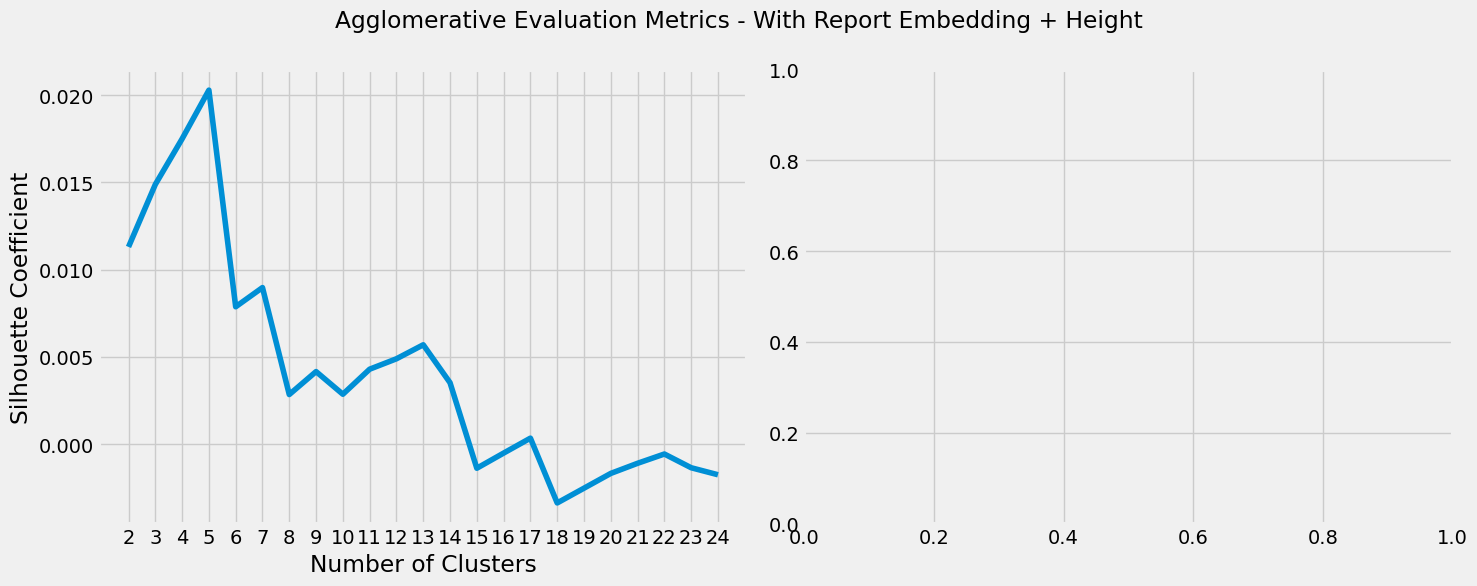

In [60]:
plot_silhouette_scores("ac", X_data, 2, 25, 1)

In [61]:
CLUSTERS = 4

In [62]:
clustering = AgglomerativeClustering(n_clusters=CLUSTERS).fit(X_data)
X['label'] = clustering.labels_

get_top_keywords(X_vect, X.label, vectorizer.get_feature_names_out(), 15)



Cluster 0
bodi,foot,littl,point,score,goal,winger,even,man,frame,area,goali,around,big,size

Cluster 1
much,project,space,scout,offens zone,find,though,line,even,first,winger,six,point,goal,score

Cluster 2
size,line,close,blue line,pair,blue,transit,pressur,attack,point,mobil,gap,defenceman,rush,defenseman

Cluster 3
teammat,playmak,averag,impress,score,effect,battl,size,chanc,vision,strength,hockey,creativ,smart,possess


In [63]:
visualize_results(X)
#visualize_results_umap(X_vect, X)

ValueError: Mime type rendering requires nbformat>=4.2.0 but it is not installed

Top-5 most similar pairs:
Tyson Jost 	 Brock Boeser 	 0.9326
Aleksi Heponiemi 	 Sam Steel 	 0.9300
Jacob Larsson 	 Jeremy Roy 	 0.9284
Leo Carlsson 	 David Edstrom 	 0.9274
Mikko Rantanen 	 Jake Virtanen 	 0.9265
Liam Ohgren 	 Oskar Olausson 	 0.9258
Axel Sandin Pellikka 	 Quinn Hughes 	 0.9256
Matthew Barzal 	 Josh Ho-Sang 	 0.9252
Kyle Connor 	 Nick Merkley 	 0.9250
Adrien Kempe 	 Ivan Barbashev 	 0.9250


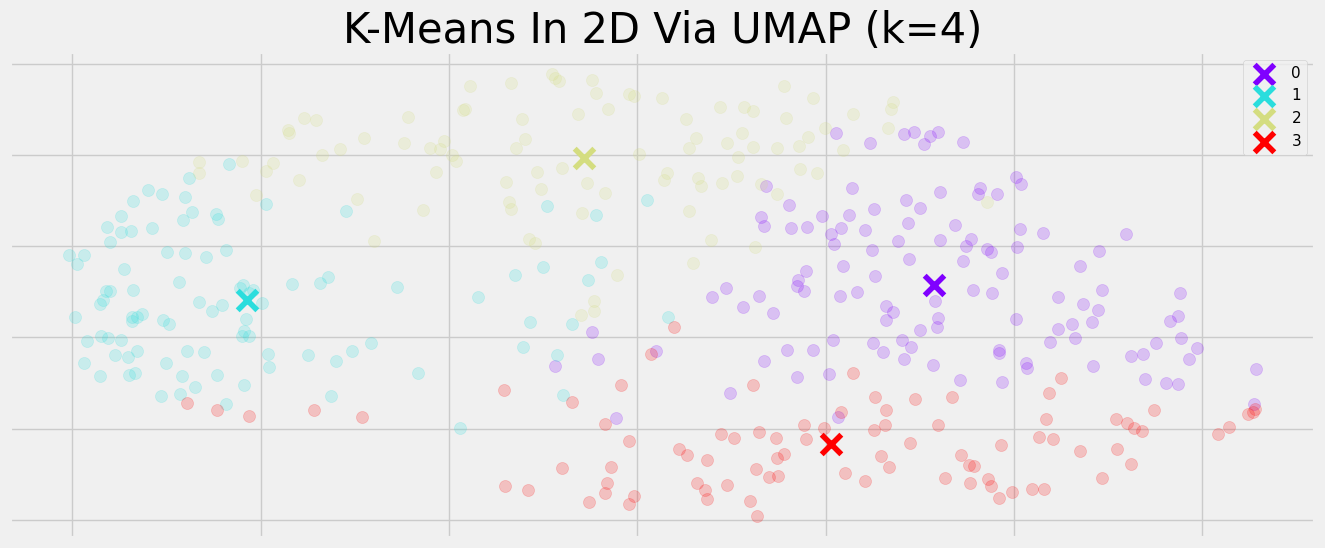

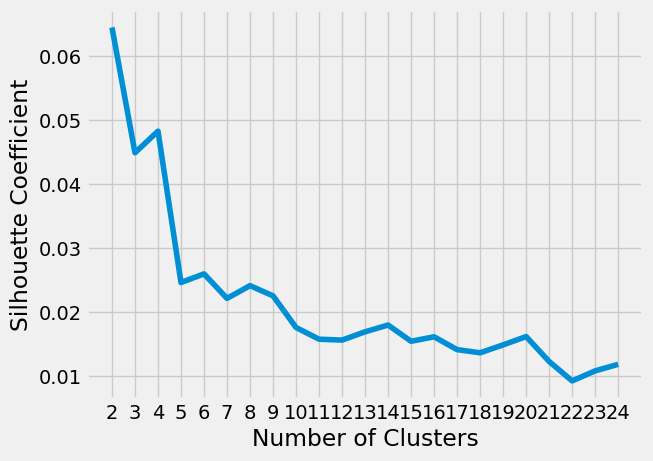

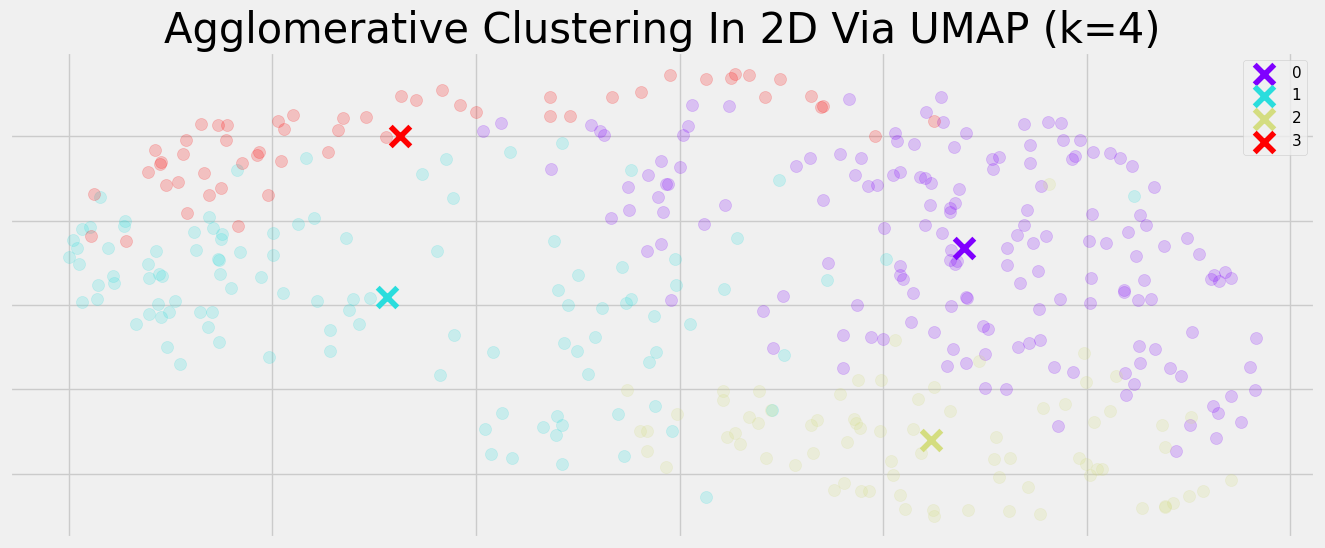

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=09d8dc5c-d54b-4729-bd12-f4067dd931f4' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>